In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_log1pexp import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor, unit_circle, arcosh
from torch import autograd
torch.manual_seed(42)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R.item()-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

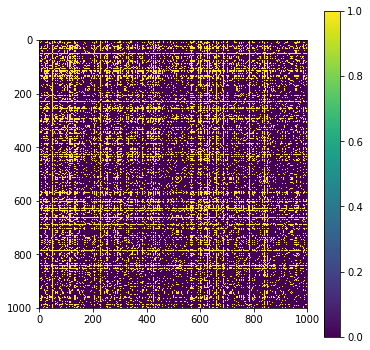

In [5]:
N = 1000
R = torch.tensor([6.0]).double()
alpha = .55
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
#G.plot()

In [6]:
for t in range(1):
    #try:
        r_init = noise_r(r, R, rel_var=0.1)
        phi_init = noise_phi(theta, 0.1)

        r_loc_init = logit(r_init/R)
        r_scale_init = (torch.ones([N]).double()/10).log()
        phi_loc_init = polar2cart(1, phi_init)
        phi_scale_init = (torch.ones([N]).double()*30).log()
        R_conc_init = torch.tensor(10.).log()
        R_scale_init = torch.tensor(1.).log()
        alpha_conc_init = torch.tensor(.5).log()
        alpha_scale_init = torch.tensor(.5).log()
        T_init = torch.tensor([3.,10.]).log()
        dataloader = DataLoader(EdgesDataset(A), batch_size=int(N**2/8), shuffle=True, num_workers=0)
        vi = VI_HRG(N,20, init_values={'rs_loc':r_loc_init,
                                        'rs_scale':r_scale_init,
                                      'phis_loc':phi_loc_init,
                                      'phis_scale':phi_scale_init, 
                                      'R_conc':R_conc_init, 
                                      'R_scale':R_scale_init,
                                      'alpha_conc':alpha_conc_init,
                                      'alpha_scale':alpha_scale_init,
                                      'T':T_init},
                   fixed={'R':None, 
                          'T':None,
                          'alpha':None},
                   priors={'R_p':torch.tensor([20., 0.4]), 
                            'T_p':torch.tensor([1., 15.]),
                            'alpha_p':torch.tensor([27., 0.03])},)
        vi.train(dataloader, lrs=[0.1], debug=False, epochs=10)
        r_x_loc, r_x_scale, phi_x_loc, phi_x_scale, R_x_conc, R_x_scale, T_x, \
            alpha_x_conc, alpha_x_scale = vi.constrained_params()
        hist_samples = [5000]
        bins = 30
        R_samples = Gamma(R_x_conc, R_x_scale.reciprocal()).sample(hist_samples)
        alpha_samples = Gamma(alpha_x_conc, alpha_x_scale.reciprocal()).sample(hist_samples)
        T_samples = Beta(T_x[0], T_x[1]).sample(hist_samples)
        plt.figure(figsize=(8,12))
        
        plt.subplot(3, 1, 1)
        plt.hist(R_samples.numpy(), bins=bins)
        plt.axvline(R.item(), color='r')
        plt.title('Estimated R')
        
        plt.subplot(3, 1, 2)
        plt.hist(alpha_samples.numpy(), bins=bins)
        plt.axvline(alpha, color='r')
        plt.title('Estimated alpha')
        
        plt.subplot(3, 1, 3)
        plt.hist(T_samples.numpy(), bins=bins)
        plt.axvline(T, color='r')
        plt.title('Estimated T')
        plt.show()
        print('Likelihood:', vi.likelihood())
    #except:
    #    pass

>>>>>>>>>>>> Start training...


KeyboardInterrupt: 